# <center>Airbnb Renting Scene in Seattle</center>
***
<img src="seattle-by-oakie-unsplash.jpg" alt="high rise buildings by Oakie - Unsplash" title="Seattle high rise buildings by Oakie - Unsplash" style ="width: 1000px;"/>

### Business Understanding 
In this project, I am using the Seattle Airbnb open dataset 2016-2017 from Kaggle to discover a few key aspects of the Airbnb renting scene in Seattle. The information can be used to help potential hosts assess the possibility of using their properties for Airbnb renting, for guests to consider using Airbnb as accomodation options, and for current hosts or Airbnb itself to assess the sentiment of guests using their services. 

A few questions this project seeks to understand are: 
1. What is the average listing Price based on Location/Seattle Neighborhood
2. What is the occupancy pattern based on Weekday and season 
3. What are the earnings and reviews by host 
4. How much should the host set their listing price
5. And what guests say about their Airbnb experience

Answers to the first 3 questions can be found through the [visualization created in Tableau](https://public.tableau.com/profile/anh.chu#!/vizhome/Seattleairbnb/EDA) and [blog post on Medium](https://medium.com/@anhchu1291/seattle-airbnb-renting-scene-a-closer-look-powered-by-data-f7498ae57262). Answer to the 4th and 5th question can be found in the code below

***
## <center> PART 1: Data Understanding </center>
There are 3 files in the dataset: 
1. **listing.csv**: provides information about hosts, price, room types, property types, listing summary, number of reviews etc. about 3818 Airbnb listings in Seattle. 
    - There are 44 columns with missing data ranging from 0.01% to 100% missing 
    - Columns with the most missing data are: license, square feet, monthly_price, security deposit, weekly_price, notes, etc.
    - There are 2751 hosts in the data and 20% of them are superhosts (Read: [What is Superhost](https://www.airbnb.com/help/article/828/what-is-a-superhost) )
2. **calendar.csv**: provides information about occupancy and availability for 2873 listing everyday from January 2016 - January 2017
    - There are 4 columns in the calendar dataset: listing ID, Date, Availability (t: available, f: occupied), Price
    - If the listing is occupied, there will be price for that listing for that date. Therefore, price is the only column with N/A value in this dataset
3. **reviews.csv**: provides 84849 reviews for each property from 2009
    - About 3191 listings have about 85k reviews from 2009-2016 
    - 18 of these reviews have missing comments

In [1]:
# import necessary packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

# import packages for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import text 

import nltk
from nltk.tokenize import word_tokenize 
from nltk import pos_tag, bigrams, FreqDist, ne_chunk

import detectEnglish

#import packages for price prediction
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor 

In [2]:
listing = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')
review = pd.read_csv('reviews.csv')

In [3]:
print("Listing dataset has %2d records and %2d columns" %(listing.shape[0],listing.shape[1]))
print("Calendar dataset has %2d records and %2d columns" %(calendar.shape[0],calendar.shape[1]))
print("Review dataset has %2d records and %2d columns" %(review.shape[0],review.shape[1]))

Listing dataset has 3818 records and 92 columns
Calendar dataset has 1048575 records and  4 columns
Review dataset has 84849 records and  6 columns


#### a. Inspect Listing Dataset

In [4]:
listing.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3818.000000,3802.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.020000e+13,1.578556e+07,7.157757,7.157757,98115.713463,47.628961,-122.333103,3.349398,1.259469,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,16.531252,0.043052,0.031745,1.977599,0.590369,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.020000e+13,4.193000e+03,1.000000,1.000000,98101.000000,47.505088,-122.417219,1.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.020000e+13,3.275204e+06,1.000000,1.000000,98104.000000,47.609418,-122.354321,2.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.020000e+13,1.055814e+07,1.000000,1.000000,98112.000000,47.623601,-122.328874,3.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.020000e+13,2.590309e+07,3.000000,3.000000,98121.000000,47.662694,-122.310800,4.000000,1.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.020000e+13,5.320861e+07,502.000000,502.000000,98199.000000,47.733358,-122.240607,16.000000,8.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [5]:
#number of unique hosts
unique_host = listing['host_id'].unique()
'Number of unique hosts in listing dataset:', len(unique_host)

('Number of unique hosts in listing dataset:', 2751)

In [6]:
def identify_null_col(dataframe):
    """Identify columns that have missing data in the dataframe
    
    Args:
        dataframe: input dataframe to identify missing data
        
    Returns:
        dataframe: dataframe of column names as index, # missing records, % missing records
    """
    
    null_col = dataframe.columns[dataframe.isna().sum()>0]
    col_null_val = dataframe[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (dataframe[null_col].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    nulls_df = pd.DataFrame(col_null_val,columns=['#Nulls'])
    nulls_df['%Nulls']=per_null_val
    print('Number of columns with missing data:',nulls_df.shape[0])
    return nulls_df

identify_null_col(listing)

Number of columns with missing data: 44


,#Nulls,%Nulls
license,3818,100.000000
square_feet,3721,97.459403
monthly_price,2301,60.267156
security_deposit,1952,51.126244
weekly_price,1809,47.380828
notes,1606,42.063908
neighborhood_overview,1032,27.029859
cleaning_fee,1030,26.977475
transit,934,24.463070
host_about,859,22.498690


In [7]:
# %Superhosts in the dataset
listing['host_is_superhost'].value_counts()/listing.shape[0]*100

f    79.570456
t    20.377161
Name: host_is_superhost, dtype: float64

#### b. Calendar Dataset

In [8]:
#how many unique listings in calendar:
unique_listing_calendar = calendar['listing_id'].unique()
'Number of unique listings in calendar dataset:', len(unique_listing_calendar)

('Number of unique listings in calendar dataset:', 2873)

In [9]:
calendar.head()

,listing_id,date,available,price
0,241032,1/4/2016,t,$85.00
1,241032,1/5/2016,t,$85.00
2,241032,1/6/2016,f,NaN
3,241032,1/7/2016,f,NaN
4,241032,1/8/2016,f,NaN


In [10]:
identify_null_col(calendar)

Number of columns with missing data: 1


,#Nulls,%Nulls
price,348713,33.255895


#### c. Review Dataset

In [11]:
print('Number of unique listings in review dataset:',len(review['listing_id'].unique()))
print('Number of reviews', review.shape[0])
review.head()

Number of unique listings in review dataset: 3191
Number of reviews 84849


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [12]:
identify_null_col(review)

Number of columns with missing data: 1


,#Nulls,%Nulls
comments,18,0.021214


In [13]:
# Number of missing data in comments field (review dataset)
print('%2d missing rows in comments field' %review['comments'].isna().sum())

18 missing rows in comments field


***
## <CENTER> PART 2: Price Prediction (Regression - Supervised Learning) </CENTER>
In this part, I will predict the listing price in the **listing dataset**. 44 variables in this listing dataset have missing values, variables with majority of missing values will be dropped from the analysis. In this analysis, only 10 variables will be used for prediction: 5 continous variables, 5 categorical variables

### 3. Data Preparation for Price Prediction

- **Step 1 - Clean target variable/price**: cast the data type of price column from string to float. A correlation matrix between continuous variables in X shows that beds and accommodates are highly correlated to each other so #beds is dropped out of the predictor variables. Dropping this variable doesn't have any effect on final model.
- **Step 2 - Split data for training and test set**:  Split train and test set using StratifiedShuffleSplit to reserve the proportion of listing by location as location is likely to have influence on price 
- **Step 3 - Prepare the Training Dataset (Dealing with missing values + scale continuous variables + One Hot Encoding categorical data)**: 5 variables used in the analysis have missing values. As the number of missing vales are less than 1%, the missing values for discrete variables were imputed with median, and categorical variables were imputed with most_frequent values.  The continuous variables are scaled using StandardScaler to use for prediction. 7 categorical data including neighborhood, zipcode, property_type, etc. are encoded because linear regression cannot work with categorical variables
- **Step 4 - Prepare the Test Dataset**: Repeat Step 3 for Testset

##### Step 1: Clean target variable and check correlation between continuous variables

In [14]:
#clean the 'price' column and convert to float64
listing['cleaned_price'] = listing['price'].str.replace("$","")
listing['cleaned_price']  = listing['cleaned_price'].str.replace("'","")
listing['cleaned_price'] = listing['cleaned_price'].str.replace(",","")
listing['cleaned_price'] = listing['cleaned_price'].astype('float')

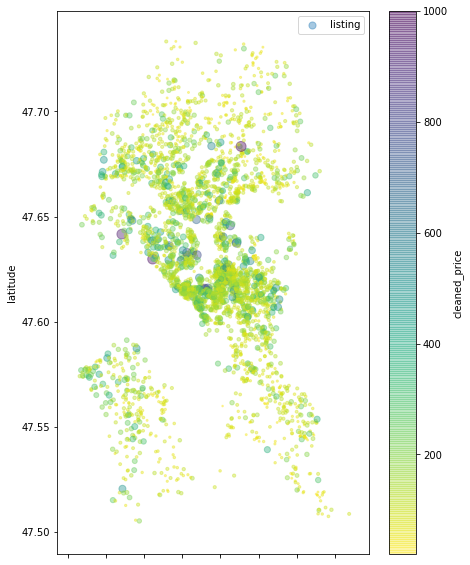

In [15]:
# Price based on geographical data
listing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4
             ,s=listing['cleaned_price']/10
             , label = 'listing'
            , c = 'cleaned_price', figsize =(7,10)
            , cmap = plt.get_cmap("viridis_r")
            , colorbar=True);

plt.legend();

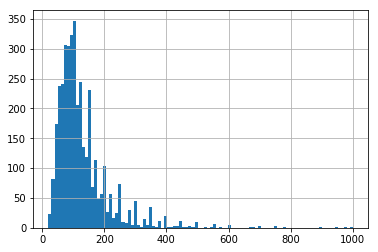

In [16]:
listing["cleaned_price"].hist(bins=100);

In [17]:
# Pick the variables for price prediction
subset_col = ['neighbourhood_group_cleansed','zipcode','room_type','bed_type','bedrooms','bathrooms','beds','host_is_superhost'
          ,'accommodates', 'number_of_reviews',"cleaned_price"]

subset = listing[subset_col]

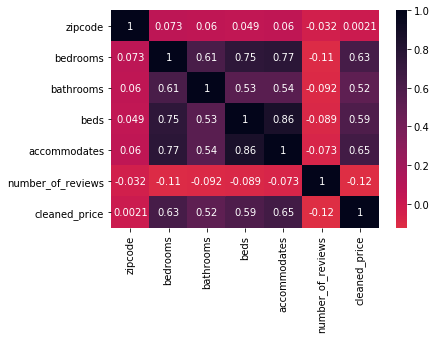

In [18]:
# A correlation matrix between continuous variables and y
corr = subset.corr()
cmap = sns.cm.rocket_r
ax = sns.heatmap(corr, annot=True, center = 0, cmap=cmap, linecolor='white')

C:\Users\152703\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\152703\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


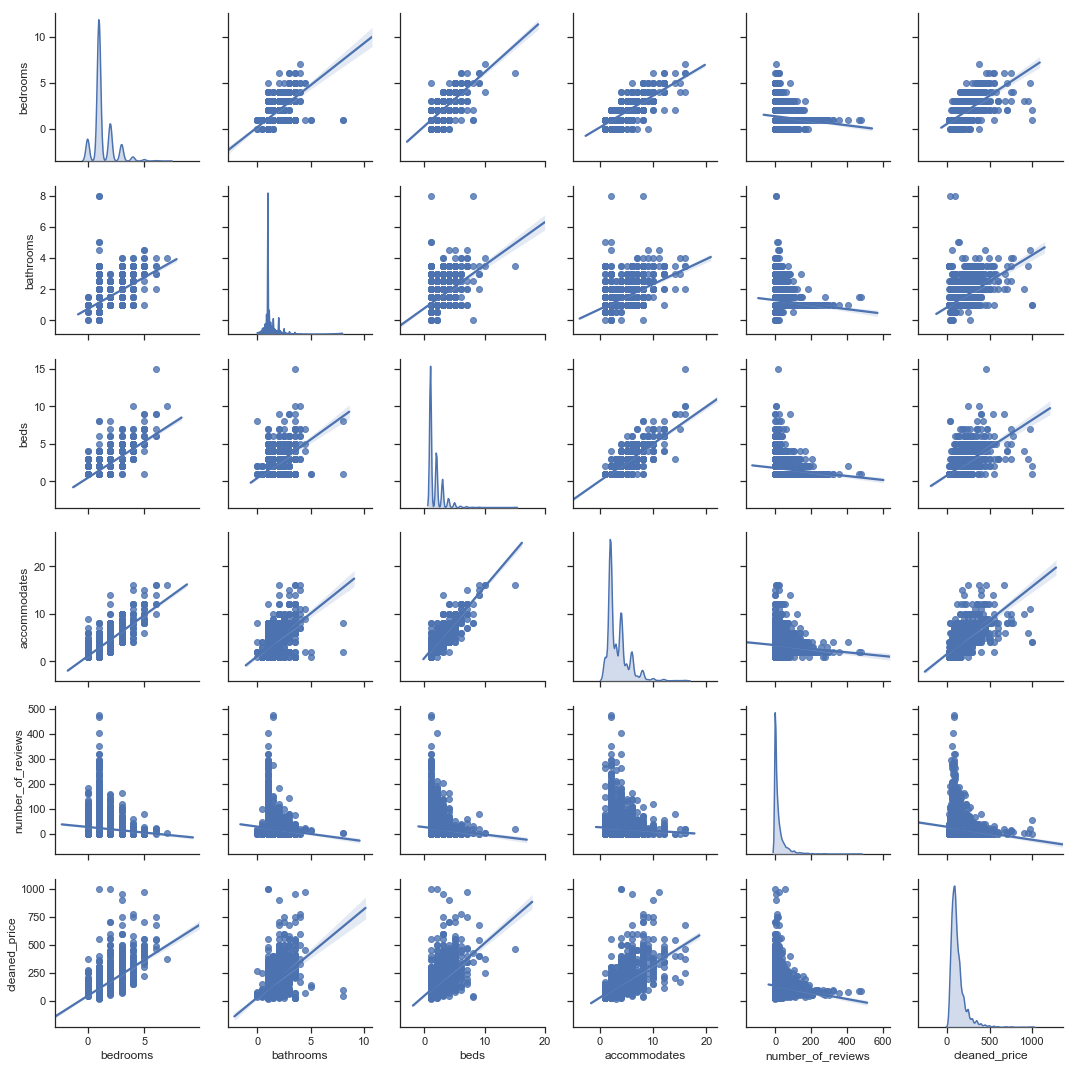

In [19]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(subset.drop('zipcode',axis=1),diag_kind='kde',palette="husl", kind='reg')

##### Step 2: Split Training and Test Set

In [20]:
# Split train and test set using StratifiedShuffleSplit to reserve the proportion of listing by location 
## as location is likely to have influence on price 

split = StratifiedShuffleSplit(n_splits=1, test_size =0.2, random_state=42)

for train_index, test_index in split.split(subset, subset['neighbourhood_group_cleansed']):
    strat_train_set = subset.loc[train_index]
    strat_test_set = subset.loc[test_index]
    
print('From {} listings, there are {} listings in train set, and {} listings in test set'
      .format(len(subset),len(strat_train_set), len(strat_test_set)))

From 3818 listings, there are 3054 listings in train set, and 764 listings in test set


In [21]:
#check the proportion of listings by neighborhood group between the original dataset and train/test set after split
subset['neighbourhood_group_cleansed'].value_counts()/len(subset)

Other neighborhoods    0.207962
Capitol Hill           0.148507
Downtown               0.138816
Central Area           0.096647
Queen Anne             0.077266
Ballard                0.060241
West Seattle           0.053169
Rainier Valley         0.041645
University District    0.031954
Beacon Hill            0.030906
Cascade                0.023311
Northgate              0.020953
Delridge               0.020691
Lake City              0.017548
Magnolia               0.015977
Seward Park            0.011524
Interbay               0.002881
Name: neighbourhood_group_cleansed, dtype: float64

In [22]:
strat_test_set['neighbourhood_group_cleansed'].value_counts()/len(strat_test_set)

Other neighborhoods    0.208115
Capitol Hill           0.147906
Downtown               0.138743
Central Area           0.096859
Queen Anne             0.077225
Ballard                0.060209
West Seattle           0.053665
Rainier Valley         0.041885
University District    0.031414
Beacon Hill            0.031414
Cascade                0.023560
Northgate              0.020942
Delridge               0.020942
Lake City              0.017016
Magnolia               0.015707
Seward Park            0.011780
Interbay               0.002618
Name: neighbourhood_group_cleansed, dtype: float64

In [23]:
strat_train_set['neighbourhood_group_cleansed'].value_counts()/len(strat_train_set)

Other neighborhoods    0.207924
Capitol Hill           0.148657
Downtown               0.138834
Central Area           0.096595
Queen Anne             0.077276
Ballard                0.060249
West Seattle           0.053045
Rainier Valley         0.041585
University District    0.032089
Beacon Hill            0.030779
Cascade                0.023248
Northgate              0.020956
Delridge               0.020629
Lake City              0.017682
Magnolia               0.016045
Seward Park            0.011460
Interbay               0.002947
Name: neighbourhood_group_cleansed, dtype: float64

In [24]:
X_train = strat_train_set.drop(['cleaned_price','beds'],axis=1)
y_train = strat_train_set['cleaned_price']

X_test = strat_test_set.drop(['cleaned_price','beds'],axis=1)
y_test = strat_test_set['cleaned_price']

In [25]:
X_train.head()

,neighbourhood_group_cleansed,zipcode,room_type,bed_type,bedrooms,bathrooms,host_is_superhost,accommodates,number_of_reviews
1651,Downtown,98104,Entire home/apt,Real Bed,0.0,1.0,f,1,0
495,Queen Anne,98119,Entire home/apt,Real Bed,2.0,1.0,t,4,7
605,Central Area,98122,Entire home/apt,Real Bed,1.0,1.0,f,3,181
1832,Other neighborhoods,98117,Private room,Real Bed,1.0,1.0,f,2,22
2049,Other neighborhoods,98103,Entire home/apt,Real Bed,1.0,1.0,f,1,0


##### Step 3: Prepare Training Data

In [26]:
continuous_col=['bedrooms', 'bathrooms', 'accommodates', 'number_of_reviews']
categorical_col = [col for col in X_train.columns if col not in continuous_col]
continuous_col, categorical_col

(['bedrooms', 'bathrooms', 'accommodates', 'number_of_reviews'],
 ['neighbourhood_group_cleansed',
  'zipcode',
  'room_type',
  'bed_type',
  'host_is_superhost'])

In [27]:
#impute missing values using most_frequent values for categorical variables
# and median for discrete variables (#beds, #bedrooms etc)
imp_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_frequent.fit(X_train[categorical_col])
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train[continuous_col])

# scale discrete and continuous variables
scaler = StandardScaler()
scaler.fit(X_train[continuous_col])

C:\Users\152703\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
def clean_data(df, categorical_col, continuous_col, imp_frequent, imp_median, scaler):

    """
    Function to clean training and test datasubset including: impute missing values, scale continuous data, 
    and one-hot-encode categorical data

    Args: 
        df: dataframe subset (training_set, test_set), only predictor variables X required
        categorical_col: list of col with categorical data
        continuous_col: list of col with continuous data

    Returns: 
        df: return the clean dataframe X for prediction
    """

    categorical_X = pd.DataFrame(imp_frequent.transform(df[categorical_col]),columns = categorical_col)
    
    continuous_X = pd.DataFrame(imp_median.transform(df[continuous_col]),columns = continuous_col)
    
    scaled_X = pd.DataFrame(scaler.transform(continuous_X),columns=continuous_col)

    # Create dummy variables for categorical data
    encoded_X = pd.get_dummies(categorical_X)
    
    #combined dummy variables and continuous variables into one dataframe
    cleaned_X = encoded_X
    cleaned_X[['bedrooms','bathrooms','accommodates','number_of_reviews']] = scaled_X
    
    print('Return dataframe with {} listings and {} columns'.format(cleaned_X.shape[0],cleaned_X.shape[1]))
    display(cleaned_X.head())
    
    return cleaned_X

In [29]:
cleaned_X_train = clean_data(X_train, categorical_col, continuous_col,imp_frequent, imp_median, scaler)

Return dataframe with 3054 listings and 58 columns


,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,host_is_superhost_f,host_is_superhost_t,bedrooms,bathrooms,accommodates,number_of_reviews
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,-1.490055,-0.444533,-1.197597,-0.590587
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0.792376,-0.444533,0.332295,-0.403832
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,-0.348840,-0.444533,-0.177669,4.238361
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,-0.348840,-0.444533,-0.687633,-0.003643
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,-0.348840,-0.444533,-1.197597,-0.590587


In [30]:
cleaned_X_test = clean_data(X_test, categorical_col, continuous_col,imp_frequent, imp_median, scaler)

Return dataframe with 764 listings and 58 columns


,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,host_is_superhost_f,host_is_superhost_t,bedrooms,bathrooms,accommodates,number_of_reviews
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,-0.348840,-0.444533,0.332295,-0.243756
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,-1.490055,-0.444533,-0.687633,-0.297115
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,1.933591,-0.444533,1.352222,1.330321
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0.792376,-0.444533,1.352222,-0.270436
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,-0.348840,-0.444533,-0.177669,0.636660


In [31]:
set(cleaned_X_train.columns)-set(cleaned_X_test.columns)

set()

### 4. Data Modelling 
2 Models are used on the training subset: Linear Regression with multiple varaiables, and Random Forest Regressor. The models are then assessed using the test subset 

In [32]:
def train_test(X, X_test,y,y_test,model):
    reg = model.fit(X,y)
    prediction = reg.predict(X)
    lin_mse_train = mean_squared_error(y,prediction)
    lin_rmse_train = np.sqrt(lin_mse_train)
    r2_train = r2_score(y,prediction)
    
    prediction_test = reg.predict(X_test)
    lin_mse_test = mean_squared_error(y_test,prediction_test)
    lin_rmse_test = np.sqrt(lin_mse_test)
    r2_test = r2_score(y_test,prediction_test)
    
    print("Training set: RMSE = {:.2f}, R2 = {:.2f}".format(lin_rmse_train,r2_train))
    print("Test set: RMSE = {:.2f}, R2 = {:.2f}".format(lin_rmse_test,r2_test))

In [33]:
lin_reg = LinearRegression()
train_test(cleaned_X_train, cleaned_X_test, y_train, y_test,lin_reg)

Training set: RMSE = 56.52, R2 = 0.59
Test set: RMSE = 68.44, R2 = 0.51


In [34]:
forest_reg = RandomForestRegressor()
train_test(cleaned_X_train, cleaned_X_test, y_train, y_test,forest_reg)

C:\Users\152703\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set: RMSE = 28.44, R2 = 0.90
Test set: RMSE = 64.90, R2 = 0.56


***
## <CENTER> PART 3: Sentiment Analysis (Lexicon based approach - Unsupervised)

### 3. Data Preparation for Sentiment Analysis 
In this part, I will prepare the review dataset for Sentiment Analysis including: 
    - Drop 18 missing comments discovered in previous part: After dropping these 18 comments, there are 84,831 comments left
    - Detect and Remove Non-English comments: There are about 840 non-English comments. 83,991 comments left after Non-English comments are removed
    - Drop Automated comments: After running the sentiment analysis, I found out 796 automated comments (e.g. 'The host canceled this reservation X days before arrival. This is an automated posting.') were classified as neutral comments. Hence, these comments are also dropped from the review dataset
    
At the end, only 83195 comments are used to classify the guest sentiment using TextBlob and VaderSentiment (2 lexicon based approaches to classify sentiment based on text data). The reason for using this approach is because this dataset is not labeled so we cannot use a supervised learning approach to train and test data. 

In [35]:
#drop missing comments
review = review.dropna(subset =['comments'],how='any')
review.shape[0]

84831

In [36]:
# to detect non-English comments, I use a helper function called detectEnglish 
## provided by http://inventwithpython.com/hacking (BSD Licensed)
review['detect_Eng'] = review['comments'].apply(lambda row: detectEnglish.isEnglish(row))
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,detect_Eng
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,True
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,True
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",True
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,True
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,True


In [37]:
non_eng = review[review['detect_Eng']==False]
print('There are {} non English comments'.format(non_eng.shape[0]))
non_eng['comments'].tail(10)

There are 840 non English comments


83869                                               Yes - 
83928    Barbara ci ha accolti nel miglior modo possibi...
83931    我们非常开心能入住Barbara And Michael的房子，房间很好，沐浴房很棒！她们还...
83944    Petite perle à Seattle! Ce logement nous a séd...
83953    Barbara und Michael empfingen uns mit offenen ...
84071    Margot è sempre stata gentile e disponibile. L...
84117    숙소가 깔끔하고 아늑했다. 주변이 조용해 휴식을 취하기에 가장 적절한 장소였다. 집...
84121    Fue agradable, los anfitriones preparan tu est...
84338    非常舒适安静的房子，床边有窗户，晚上睡觉可以看见星星月亮，房东非常热情，退房的时候我去机场，...
84846    Gran ubicación, cerca de todo lo atractivo del...
Name: comments, dtype: object

In [38]:
# Remove non-english comments from review
review = review[review['detect_Eng']==True]
review.shape[0]

83991

In [39]:
#Remove 'This is an automated posting' comments which are not real comments
review['automated_posting'] = review['comments'].apply(lambda row: "This is an automated posting" in row)
auto_posting = review[review['automated_posting']==True]
print('Sample auto comments:', auto_posting['comments'][83])
print('Number of auto comments:', auto_posting.shape[0])

Sample auto comments: The host canceled this reservation 21 days before arrival. This is an automated posting.
Number of auto comments: 796


In [40]:
review = review[review['automated_posting']==False]
print('Number of reviews after removing auto posting:', review.shape[0])

Number of reviews after removing auto posting: 83195


### 4. Data Modelling for Sentiment Analysis
Running 83195 comments through TextBlob and Vader Sentiment pipeline, we have roughly 82k Positive Comments from both; however, the number of negative and neutral comments are quite different between 2 methods. 

I go ahead and average the polarity score of both methods and classify positive comments (polarity=1), neutral comments (polarity=0), and negative comments (polarity=-1).

The final result: ***82.5k positive reviews, 545 negative reviews and 133 neutral reviews***

In [41]:
analyzer = SentimentIntensityAnalyzer()
review['review subjectivity Textblob']= review['comments'].apply(lambda row:TextBlob(row).sentiment.subjectivity                                                   )
review['review polarity Textblob']= review['comments'].apply(lambda row:TextBlob(row).sentiment.polarity)
review['review polarity Vader']= review['comments'].apply(lambda row:analyzer.polarity_scores(row)['compound'])
review['Average Polarity']=(review['review polarity Vader'] + review['review polarity Textblob'])/2

review['review Sentiment Textblob'] = np.where(review['review polarity Textblob']>= 0.01, 1, \
                                       (np.where(review['review polarity Textblob']<= -0.01, -1, 0)))

review['review Sentiment Vader'] = np.where(review['review polarity Vader']>= 0.05, 1, \
                                       (np.where(review['review polarity Vader']<=-0.05, -1, 0)))

print(review['review Sentiment Textblob'].value_counts())
print(review['review Sentiment Vader'].value_counts())


 1    82486
 0      392
-1      317
Name: review Sentiment Textblob, dtype: int64
 1    82208
-1      615
 0      372
Name: review Sentiment Vader, dtype: int64


In [42]:
review['Sentiment (lexicon)'] = np.where(review['Average Polarity']>0, 'Positive',\
                                   (np.where(review['Average Polarity']<0, 'Negative','Neutral')))
print('Combined sentiment from both methods:\n',review['Sentiment (lexicon)'].value_counts())

Combined sentiment from both methods:
 Positive    82517
Negative      545
Neutral       133
Name: Sentiment (lexicon), dtype: int64


In [43]:
review['Average Polarity'].describe()

count    83195.000000
mean         0.650490
std          0.131131
min         -0.764150
25%          0.611733
50%          0.666546
75%          0.718118
max          0.988550
Name: Average Polarity, dtype: float64

In [44]:
print('Random comments with the highest positive sentiment: \n')
cl_positive = review.loc[review['Average Polarity']>0.9,['comments']].sample(6).values
for c in cl_positive:
 print("*"+c[0])

Random comments with the highest positive sentiment: 

*Great place!! We had a wonderful visit in your beautiful city, and the aerostream was cute and very comfortable. 
Thank you!!
*We LOVED our stay at Al's home!! It was perfect for our family.
*Robert was a great host and helpful. The apartment was great in a great location!
*Well coordinated and great service.  Recommended! 
*Wonderful house, great host, good location - we loved it !!!
*We had a wonderful time at Best Ocean View in Seattle. 


In [45]:
print('Random comments with the highest neutral sentiment: \n')
cl_neutral = review.loc[review['Average Polarity']==0,['comments']].sample(5).values
for c in cl_neutral:
 print("*"+c[0])

Random comments with the highest neutral sentiment: 

*Alberto nous a très bien accueilli. Facile à joindre via l'application avant/pendant notre séjour. Son appartement est bien situé, calme,  équipé comme décrit dans l'annonce, propre. Nous avons apprécié notre séjour à Seattle et la gentillesse d'Alberto.
*The hi
*See 1st Review
*Christine left a personal note, she provided contact information for her and Johnny in case we needed anything. 
*See earlier review


In [46]:
print('Random comments with the highest negative sentiment: \n')
cl_negative = review.loc[review['Average Polarity']<-0.5,['comments']].sample(1).values
for c in cl_negative:
 print("*"+c[0])

Random comments with the highest negative sentiment: 

*This location was a serious disappointment.  It was advertised as a 3 bedroom/bath whole house/apt.  Very misleading.  It was 2 very small bedrooms with an uncomfortable futon in the small tv area.  If the futon was used as a "bedroom", there was no place to sit and watch tv or eat, since the tiny kitchen only held 2 people. There were cobwebs in every room and a "gym-like" smell in the bathroom that didn't go away even after I cleaned it.  All of the towels had to be re-washed since they smelled musty and rancid.  We discovered why when we opened the washer.  The rubber seal on the inside was completely black with mold, long term mold. The owner had a nasty attitude when we approached her about the issues but did refund our money and we left 3 days into our 8 day stay.  There were no doors between us and the 2 other floors where the owners lived, and another guest was staying.  Just curtains hung as "dividers".  Both of the beds 

### Wordcloud & Top-grams analysis
To assess the preferred words guests used to describe their experience, I also pulled out top unigram, top bigrams and top trigrams, as well as created 2 wordclouds for the positive and negative comments. 
- Step 1: Remove English stopwords from the comment texts to keep only meaningful words
- Step 2: Count the frequency of top 1 word, 2-word phrases, 3-word phrases 
- Step 3: Visualize the top n-grams with seaborn package and popular words in comment texts using WordCloud package

In [47]:
# First step: Remove stopwords, non-word characters from the comment text
eng_stopword = set(text.ENGLISH_STOP_WORDS)
review['tidy_cm'] = review['comments'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>1]))
review['tidy_cm'] = review['tidy_cm'].str.split().apply(lambda x: ' '.join(k for k in x if k.lower() not in eng_stopword))
review['tidy_cm'] = review['tidy_cm'].str.replace("n't", " not")
review['tidy_cm'] = review['tidy_cm'].str.replace("'s", " ")
review['tidy_cm'] = review['tidy_cm'].str.replace(r"[^a-zA-Z']", " ")

In [48]:
# Step 2: count the frequency by grams 
def get_top_n_gram(corpus,gram, n):
    """Return n word for unigram, bigram, trigram, etc. from corpus
    
    Args:
        corpus (str): text to obtain the grams from 
        gram (int): number of word in the phrase to extract. For example, 1: unigram, 2:bigram, 3:trigram
        n (int): number of phrases to be extracted from text. For example, 30 top unigrams, 20 top bigrams, etc. 
        
    Returns: 
        dataframe: a dataframe of top n words and their count in the text
        """
    
    vec = text.CountVectorizer(ngram_range=(gram, gram),stop_words = eng_stopword )
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [49]:
uni_grams = pd.DataFrame(get_top_n_gram(review['tidy_cm'],1,40), columns=['Words','count'])
bi_grams = pd.DataFrame(get_top_n_gram(review['tidy_cm'],2,30), columns=['Words','count'])
tri_grams = pd.DataFrame(get_top_n_gram(review['tidy_cm'],3,30), columns=['Words','count'])

In [50]:
# Step 3: Visualize top grams
def plot_gram(data):
    """Visualize the top grams dataframe with seaborn barplot
    
    Args: 
        data: dataframe of top words and their count returned from get_top_n_gram function
        
    Returns: 
        barplot: barplot of top words and their count
    """
    
    data.sort_values(by=['count'], ascending = False)
    sns.set(rc={'figure.figsize':(12,7)})
    ax = sns.barplot(x='Words', y='count', data = data, palette = 'Blues_d');
    ax.set_xticklabels(labels = data['Words'], rotation=90);
    ax.set_title('Top grams from Reviews');

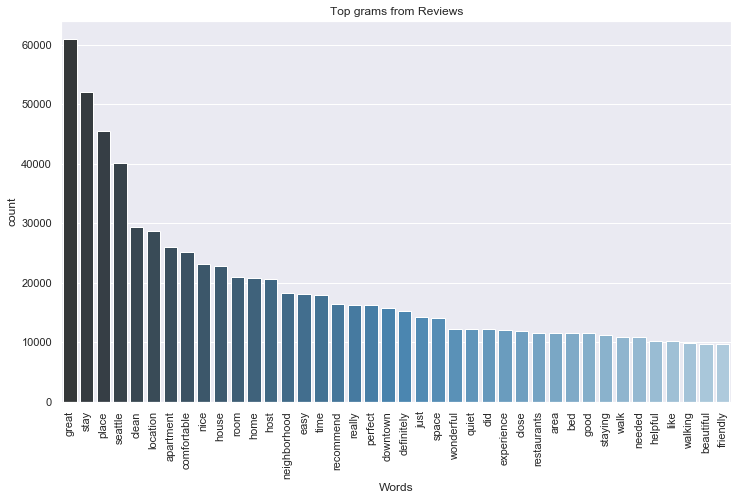

In [51]:
plot_gram(uni_grams)

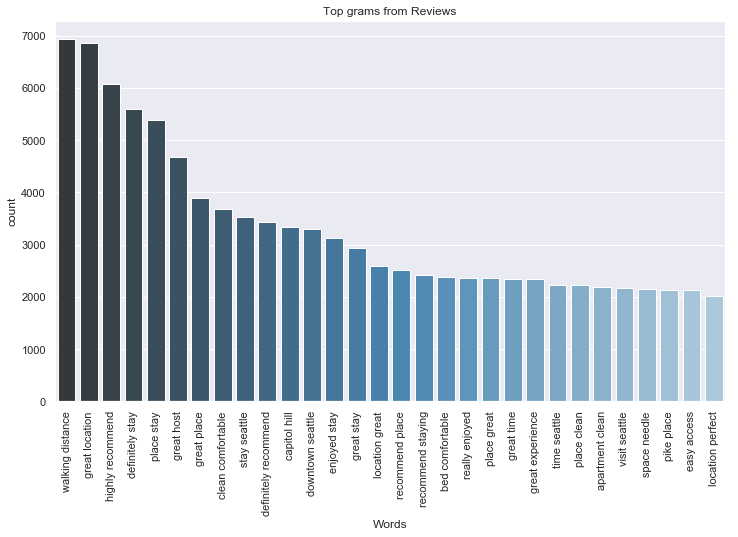

In [52]:
plot_gram(bi_grams)

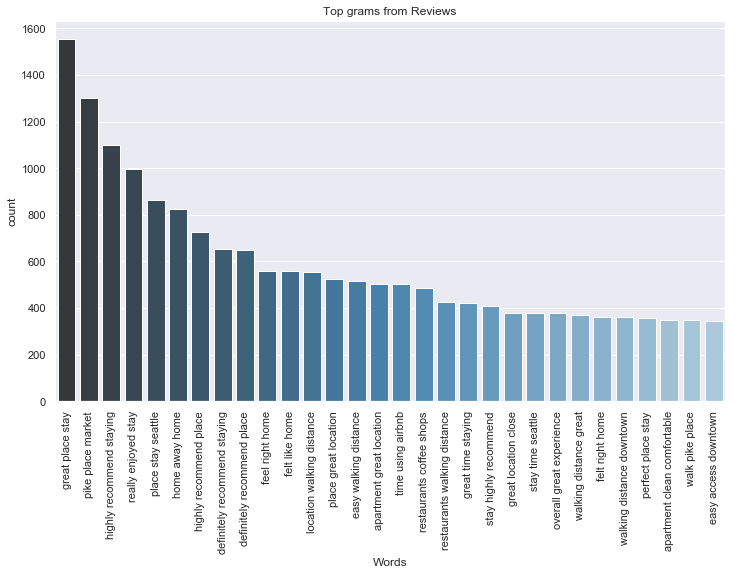

In [53]:
plot_gram(tri_grams)

In [54]:
# Import mask image for wordcloud
house_mask = np.array(Image.open("house3.png"))

In [55]:
# Create the frequency distribution for each word in text 
comments = ' '.join([text.lower() for text in review['tidy_cm']])
comments_dist = nltk.FreqDist(word for word in word_tokenize(comments))
comments_dist

FreqDist({'great': 60955, 'stay': 52102, 'place': 45498, 'seattle': 40065, 'clean': 29324, 'location': 28744, 'apartment': 26015, 'comfortable': 25194, 'nice': 23122, 'house': 22881, ...})

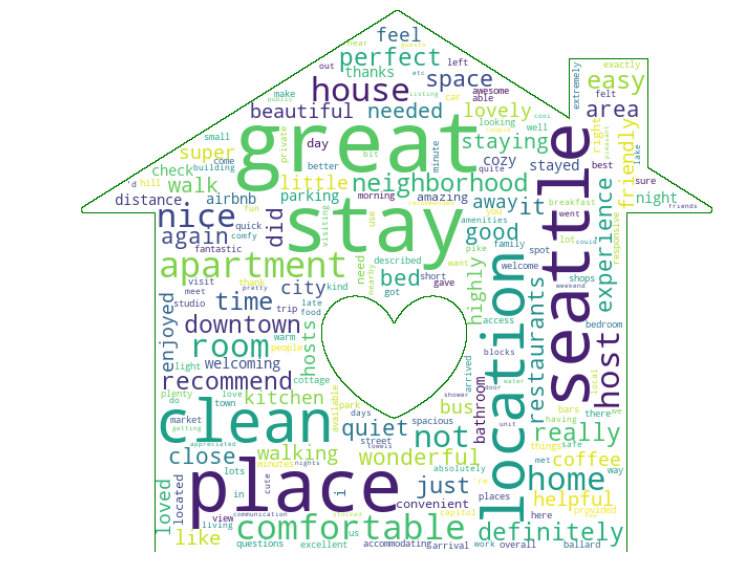

In [56]:
# Create wordcloud for all comments
wordcloud = WordCloud(width=800, height=500,background_color='white', max_font_size=80, stopwords=set(),random_state=42,\
                      mask=house_mask,contour_width=0.5,contour_color='Green')
wordcloud.generate_from_frequencies(comments_dist)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [57]:
def process1(pos_tag_list):
    """Process adjective words from negative comments
    
    Args:
        pos_tag_list: list of tokenized word and their associated Part-of-speech (POS) Tagging 
        
    Returns: 
        list: list of processed words for the negative wordcloud
    """
        
    processed_list = [] 
    i=0
    for t1, t2 in zip(pos_tag_list,pos_tag_list[1:]): 
        #if t1[0]==("able"):
         #   processed_list.append(t1[0]+"-"+t2[0])

        #elif t1[0]==("unable"):
         #   processed_list.append(t1[0]+"-"+t2[0])

        if t1[0] == "not" and (t2[1].startswith('JJ') or t2[1].startswith('VB')):
            processed_list.append(t1[0]+"-"+t2[0])

        elif t1[1].startswith('JJ') :
            processed_list.append(t1[0])

    return processed_list

In [58]:
review['pos_tag_cm'] = review['tidy_cm'].apply(lambda row:' '.join(process1(pos_tag(word_tokenize(row.lower())))))

In [59]:
neg = review[review['Sentiment (lexicon)']=='Negative']

In [60]:
neg_comments = ' '.join([text.lower() for text in neg['pos_tag_cm']])
neg_dist = nltk.FreqDist(word for word in word_tokenize(neg_comments))
neg_dist

FreqDist({'clean': 108, 'great': 100, 'nice': 96, 'good': 85, 'seattle': 74, 'small': 64, 'able': 52, 'airbnb': 48, 'overall': 48, 'comfortable': 48, ...})

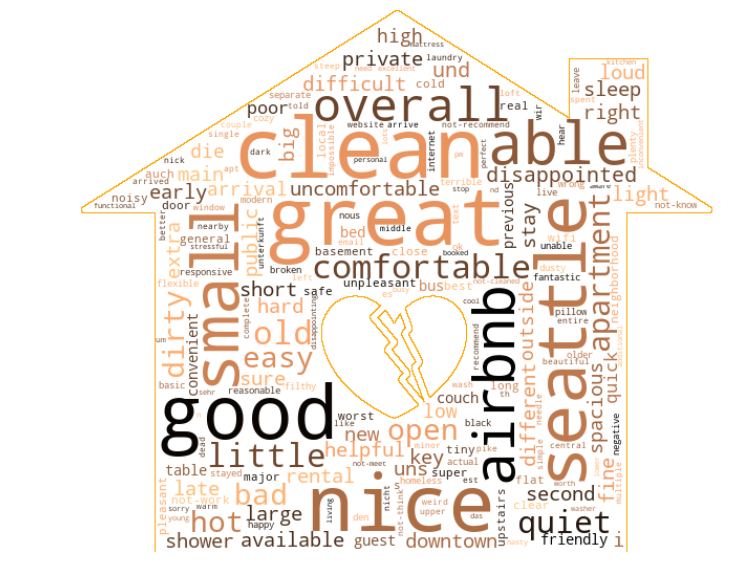

In [61]:
house_mask2 = np.array(Image.open("house4.png"))

wordcloud = WordCloud(width=800, height=500,background_color='white', max_font_size=80, colormap="copper", stopwords=set(),random_state=42,\
                      mask=house_mask2,contour_width=0.5,contour_color='orange')
wordcloud.generate_from_frequencies(neg_dist)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()
                

## <center> Evaluate the result </center>
Based on the data visualization in Tableau, the prediction model and the sentiment analysis, we can come up with observations as below: 
1. The model of 10 variables: 5 continuous and 5 categorical variables can explain around 54% of the listing price in the dataset. Location is one of a factor affecting listing price
2. Occupancy rate tends to be higher in summer; 
3. Hosts can earn money with their Airbnb venture; 
4. Overall, Airbnb hosts receive good ratings although super hosts tend to rank higher than regular hosts
5. And a majority of guests have positive experience with their Airbnb experience

#### Reference and Credit
1. [Visualizing Data with Pairs Plots in Python - Will Koehrsen](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
2. [A Complete Exploratory Data Analysis and Visualization for Text Data - Susan Li](https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a)
3. Hands-on Machine Learing with Scikit-Learn and TensorFlow - Aurelien Geron